In [2]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import letRun #This library can be deleted, it is used for debugging
import RoboSkin as sk
import cv2 
import pickle

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


def sigmoid(x):                                        
   return 1 / (1 + np.exp(-x))

In [18]:
##DATA SET CREATOR
class dataset:
    def __init__(self,names=["flat_detection.avi","edge_detection.avi","flat_slip_detection.avi"]):
        self.path=letRun.path
        self.names=names
        self.SIZE=0.3
        name="C:/Users/dexte/OneDrive/Documents/AI/Data_Labeller/pickle_imputer_small.pkl" #use standard imputer or one for small
        self.reg=None
        with open(name,'rb') as file:
            self.reg=pickle.load(file)
    def predict(self,reg,dat):
        p=reg.predict(dat)
        p=(p.reshape((p.shape[0],p.shape[1]//2,2))*255/self.SIZE)
        return p
    def generate(self,STORE=10,y_labels=[]):
        BIG_DATA_X=None
        BIG_DATA_y=None
        assert len(y_labels)==len(self.names),"Incorrect length of labels"
        for j,name in enumerate(self.names):
            skin=sk.Skin(videoFile=self.path+name)#videoFile=path+"Movement4.avi") #load skin object using demo video
            cap = cv2.VideoCapture(self.path+name)
            length = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
            skin.sharpen=False #falsify the sharpness if recorded with sharpness
            frame=skin.getFrame()
            h=frame.shape[1]*self.SIZE
            w=frame.shape[0]*self.SIZE
            frame=cv2.resize(frame,(int(h),int(w)),interpolation=cv2.INTER_AREA)
            frame = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY).flatten()/255
            past=self.predict(self.reg,np.array([frame]))[0]
            initial=past.copy()
            initial_frame=frame.copy()

            X=[]
            y=[] #label as [edge surface soft hard slippery]
            lastFrames=[]
            for i in range(length): #lop through all
                frame_=skin.getFrame()
                frame=cv2.resize(frame_,(int(h),int(w)),interpolation=cv2.INTER_AREA)
                frame = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY).flatten()/255
                points=self.predict(self.reg,np.array([frame]))[0]
                #get pressure map
                diff=np.sum(np.abs(initial_frame-frame))/(frame.shape[0]*3)
                vecs=initial-points
                lastFrames.append(vecs)
                if len(lastFrames)>STORE: lastFrames.pop(0)
                if diff>0.01 and len(lastFrames)==STORE: #significant contact
                    X.append(np.array(lastFrames)) #store temporal element
                    y.append(y_labels[j])
            if type(BIG_DATA_y)==type(None):
                BIG_DATA_y=np.array(y.copy())
                BIG_DATA_X=np.array(X.copy())
            else:
                BIG_DATA_y= np.concatenate((np.array(y.copy()),BIG_DATA_y))
                BIG_DATA_X= np.concatenate((np.array(X.copy()),BIG_DATA_X))
        a,b=np.array(BIG_DATA_X),np.array(BIG_DATA_y)
        a=a.reshape((a.shape))
        return a,b

d=dataset()
x,y=d.generate(STORE=5,y_labels=[[0,1,0,1,0],[1,0,0,1,0],[0,1,0,0,1]])


In [21]:
path="C:/Users/dexte/github/RoboSkin/Code/Models/labeller/"
lin_path="/its/home/drs25/Documents/GitHub/RoboSkin/Code/Models/labeller"

#load datasets
X1=np.load(path+"X_data_push.npy")
y1=np.load(path+"y_data_push.npy")

X2=np.load(path+"X_data_edge.npy")
y2=np.load(path+"y_data_edge.npy")

X3=np.load(path+"X_data_slip.npy")
y3=np.load(path+"y_data_slip.npy")

#merge datasets
X=np.concatenate([X1,X2,X3])
SIZE=X.shape[1]
Xa=X.reshape((X.shape[0],133*2*SIZE))/100
ya=np.concatenate([y1,y2,y3])/10

X, data_test, y, labels_test = train_test_split(Xa, ya, test_size=0.20, random_state=42)

print(X.shape,y.shape)
print(data_test.shape,labels_test.shape)

(1032, 2660) (1032, 5)
(259, 2660) (259, 5)


In [22]:

# Define the size of the input (n) and output (m) layers
n_inputs = 133*2*SIZE
m_outputs = len(y[0])


# Convert data to PyTorch tensors
X_tensor = torch.tensor(X, dtype=torch.float32).to(device)
y_tensor = torch.tensor(y, dtype=torch.float32).to(device)

# Define the neural network model
class SimpleNeuralNetwork(nn.Module):
    def __init__(self, input_size, output_size,layers=[100,10],drop_out_prob=0.2):
        super(SimpleNeuralNetwork, self).__init__()
        self.fc=[nn.Linear(input_size, layers[0])]
        self.fc.append(nn.ReLU())
        self.fc.append(nn.Dropout(p=drop_out_prob))
        for i in range(1,len(layers)): #create layers 
                self.fc.append(nn.Linear(layers[i-1], layers[i]))
                self.fc.append(nn.ReLU())
                self.fc.append(nn.Dropout(p=drop_out_prob))
        self.fc.append(nn.Linear(layers[-1], output_size))
        self.fc_layers = nn.Sequential(*self.fc)
    def forward(self, x):
        x=self.fc_layers(x)
        return x

# Create the neural network
model = SimpleNeuralNetwork(n_inputs, m_outputs).to(device)

# Define the loss function and optimizer
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.01)



In [23]:
# Training loop
def get_acc(model,predictions,should_be=[]):
    predictions*=10 #normalize
    pred_array=np.zeros_like(predictions)
    inds=np.argmax(predictions[:,0:2],axis=1) #convert at threshold
    inds2=np.argmax(predictions[:,2:-1],axis=1) #convert at threshold
    for i in range(len(pred_array)):
        pred_array[i][inds[i]]=1
        pred_array[i][2+inds2[i]]=1
    correct=0
    for j,pred in enumerate(pred_array): #loopthrough predictions
        inds=np.where(pred==1) #
        if len(should_be)>0: #validation task
            sb=should_be[j]*10
            sb=np.where(sb==1)
            if len(sb[0])==len(inds[0]):
                c=0
                for i in range(len(sb[0])):
                    if sb[0][i]==inds[0][i]: c+=1
                if c==len(sb[0]): correct+=1
    return correct/len(should_be)

def train(model,num_epochs=1500):
    loss_ar=[]
    accuracies=[]
    for epoch in range(num_epochs):
        # Forward pass
        y_pred = model(X_tensor)

        # Compute the loss
        loss = criterion(y_pred, y_tensor)

        # Zero gradients, backward pass, and update the weights
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        loss_ar.append(loss.item())
        #predict
        predictions = model(torch.tensor(X, dtype=torch.float32))
        accuracies.append(get_acc(model,predictions.detach().numpy(),should_be=y))
        # Print the current loss to monitor training progress
        if epoch%1000==0:
            print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}","Accuracy",accuracies[-1])
    return np.array(loss_ar),np.array(accuracies)



In [ ]:
plt.title("Loss while training tactile model")
plt.ylabel("Loss and accuracy/5")
plt.xlabel("Epoch")
a,b=train(model)
#plt.plot(a,label="Loss")
plt.plot(b,label="Accuracy")
plt.legend(loc="upper right")
plt.show()

In [36]:
# After training, you can use the trained model for predictions on new data.
# For example, if you have new input data 'X_new', you can do:
with torch.no_grad():
     model.eval()
     predictions = model(torch.tensor(data_test, dtype=torch.float32))


def predict(predictions,should_be=[]):
    predictions*=10 #normalize
    pred_array=np.zeros_like(predictions)
    inds=np.argmax(predictions[:,0:2],axis=1) #convert at threshold
    inds2=np.argmax(predictions[:,2:-1],axis=1) #convert at threshold
    for i in range(len(pred_array)):
        pred_array[i][inds[i]]=1
        pred_array[i][2+inds2[i]]=1
    names=["edge", "surface", "soft", "hard", "slippery"]
    array=[]
    correct=0
    for j,pred in enumerate(pred_array): #loopthrough predictions
        inds=np.where(pred==1) #
        ar=[]
        if len(should_be)>0: #validation task
            sb=should_be[j]*10
            sb=np.where(sb==1)
            if len(sb[0])==len(inds[0]):
                c=0
                for i in range(len(sb[0])):
                    if sb[0][i]==inds[0][i]: c+=1
                if c==len(sb[0]): correct+=1
        for i in inds[0]:
            ar.append(names[i])
        array.append(ar)
    if correct!=0: print("Percentage correct:",(correct/len(should_be))*100,"%")
    return array

p=predict(predictions,should_be=labels_test)
p[0:10]  

Percentage correct: 62.54826254826254 %


[['surface', 'hard'],
 ['surface', 'hard'],
 ['surface', 'hard'],
 ['surface', 'hard'],
 ['surface', 'hard'],
 ['surface', 'hard'],
 ['edge', 'hard'],
 ['surface', 'hard'],
 ['edge', 'hard'],
 ['surface', 'hard']]

# Experiments

### With and without slippage

Trial A 0 Acc: 0.0
Epoch [1/1500], Loss: 0.0385 Accuracy 0.26453488372093026
Epoch [1001/1500], Loss: 0.0005 Accuracy 0.5155038759689923
Trial A 1 Acc: 0.3127413127413127
Epoch [1/1500], Loss: 0.0473 Accuracy 0.018410852713178296
Epoch [1001/1500], Loss: 0.0005 Accuracy 0.5174418604651163
Trial A 2 Acc: 0.416988416988417
Epoch [1/1500], Loss: 0.0290 Accuracy 0.29457364341085274
Epoch [1001/1500], Loss: 0.0007 Accuracy 0.31589147286821706
Trial A 3 Acc: 0.46911196911196906
Epoch [1/1500], Loss: 0.0278 Accuracy 0.11337209302325581
Epoch [1001/1500], Loss: 0.0005 Accuracy 0.5319767441860465
Trial A 4 Acc: 0.5003861003861003
Epoch [1/1500], Loss: 0.0355 Accuracy 0.5474806201550387
Epoch [1001/1500], Loss: 0.0018 Accuracy 0.31589147286821706
Trial A 5 Acc: 0.47232947232947237
Epoch [1/1500], Loss: 0.0275 Accuracy 0.28294573643410853
Epoch [1001/1500], Loss: 0.0005 Accuracy 0.5339147286821705
Trial A 6 Acc: 0.4942084942084942
Epoch [1/1500], Loss: 0.0514 Accuracy 0.14631782945736435
Epoch [1

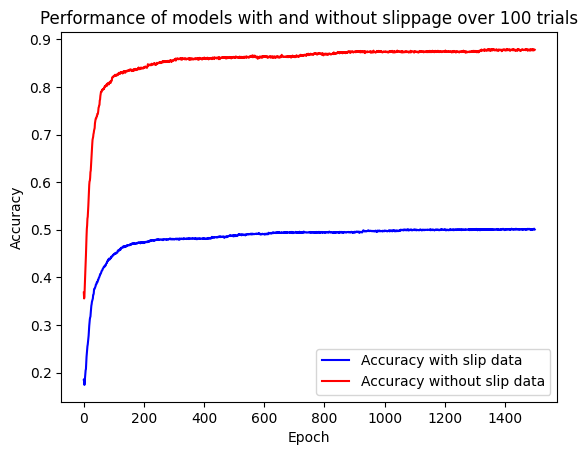

In [45]:
average_l1=np.zeros((1500,))
average_a1=np.zeros((1500,))

X, data_test, y, labels_test = train_test_split(Xa, ya, test_size=0.20, random_state=42)
X_tensor = torch.tensor(X, dtype=torch.float32).to(device)
y_tensor = torch.tensor(y, dtype=torch.float32).to(device)

p=0
TRIALS=100
for i in range(TRIALS):
    print("Trial A",i,"Acc:",p/(i+1))
    # Create the neural network
    model = SimpleNeuralNetwork(n_inputs, m_outputs).to(device)

    # Define the loss function and optimizer
    criterion = nn.MSELoss()
    optimizer = optim.Adam(model.parameters(), lr=0.01)
    l,a=train(model)
    average_l1+=np.array(l)
    average_a1+=np.array(a)

    #unseen data
    with torch.no_grad():
        model.eval()
        predictions = model(torch.tensor(data_test, dtype=torch.float32))
    p+=get_acc(model,predictions,should_be=labels_test)
average_l1=average_l1/TRIALS
average_a1=average_a1/(TRIALS) #average by 10 and then divide by 5 for scaling
p/=TRIALS
#plt.plot(average_l,'--',c="b",label="Loss with slip data")
plt.plot(average_a1,c="b",label="Accuracy with slip data")


#without slippage
#merge datasets
X=np.concatenate([X1,X2])
SIZE=X.shape[1]
X=X.reshape((X.shape[0],133*2*SIZE))/100
y=np.concatenate([y1,y2])/10

X, data_test, y, labels_test = train_test_split(X, y, test_size=0.20, random_state=42)
X_tensor = torch.tensor(X, dtype=torch.float32).to(device)
y_tensor = torch.tensor(y, dtype=torch.float32).to(device)

average_l=np.zeros((1500,))
average_a=np.zeros((1500,))
p_=0

for i in range(TRIALS):
    print("Trial B",i,"Acc:",p_/(i+1))
    # Create the neural network
    model = SimpleNeuralNetwork(n_inputs, m_outputs).to(device)

    # Define the loss function and optimizer
    criterion = nn.MSELoss()
    optimizer = optim.Adam(model.parameters(), lr=0.01)
    l,a=train(model)
    average_l+=np.array(l)
    average_a+=np.array(a)
    #unseen data
    with torch.no_grad():
        model.eval()
        predictions = model(torch.tensor(data_test, dtype=torch.float32))
    p_+=get_acc(model,predictions,should_be=labels_test)

average_l=average_l/TRIALS
average_a=average_a/(TRIALS) #average by 10 and then divide by 5 for scaling
p_/=TRIALS

print("Accuracies",p,p_)
plt.title("Performance of models with and without slippage over 100 trials")
plt.ylabel("Accuracy")
plt.xlabel("Epoch")
#plt.plot(average_l,c="r",label="Loss without slip data")
plt.plot(average_a,c="r",label="Accuracy without slip data")
plt.legend(loc="lower right")
plt.show()

In [26]:
print(np.std(average_a),np.std(average_a1))

0.05983560609199703

### Store size

In [33]:
TRIALS=1
TIMES=15
average_a=np.zeros((TIMES,1500))

for i in range(TIMES):
    print(i)
    d=dataset()
    x,y=d.generate(STORE=i,y_labels=[[0,1,0,1,0],[1,0,0,1,0],[0,1,0,0,1]])
    SIZE=x.shape[1]
    n_inputs = 133*2*SIZE
    m_outputs = len(y[0])
    for j in range(TRIALS):
        x=x.reshape((x.shape[0],133*2*SIZE))/100
        y=y/10
        X, data_test, y, labels_test = train_test_split(x, y, test_size=0.20, random_state=42)
        X_tensor = torch.tensor(X, dtype=torch.float32).to(device)
        y_tensor = torch.tensor(y, dtype=torch.float32).to(device)
        
        model = SimpleNeuralNetwork(n_inputs, m_outputs).to(device)
        # Define the loss function and optimizer
        criterion = nn.MSELoss()
        optimizer = optim.Adam(model.parameters(), lr=0.01)
        l,a=train(model)
        average_a[i]+=a
    average_a[i]/=TRIALS #get average
#diplay
plt.title("Performance of models with different sizes of temporal information")
plt.ylabel("Accuracy")
plt.xlabel("Epoch")
#plt.plot(average_l,c="r",label="Loss without slip data")
for i,dat in enumerate(average_a):
    plt.plot(dat,label="T="+str(i))

plt.legend(loc="lower right")
plt.show()

0


c:\Users\dexte\AppData\Local\Programs\Python\Python310\lib\site-packages\torch\nn\init.py:403: UserWarning: Initializing zero-element tensors is a no-op
  warnings.warn("Initializing zero-element tensors is a no-op")


Epoch [1/1500], Loss: 0.0164 Accuracy 0.0
Epoch [1001/1500], Loss: 0.0018 Accuracy 0.3223938223938224
1
Epoch [1/1500], Loss: 0.0368 Accuracy 0.0
Epoch [1001/1500], Loss: 0.0004 Accuracy 0.5366795366795367
